<center>Провведемо аналіз данних</center>

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

In [140]:
data_dir = '../airbus_test_project/dataset/' #посилання на папку, в якій знаходиться база данних
data = pd.read_csv(os.path.join(data_dir, 'train_ship_segmentations_v2.csv'))
data['EncodedPixels'] = data['EncodedPixels'].astype('string')

In [141]:
data

,ImageId,EncodedPixels
0,00003e153.jpg,<NA>
1,0001124c7.jpg,<NA>
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,<NA>
231719,ffff2aa57.jpg,<NA>
231720,ffff6e525.jpg,<NA>
231721,ffffc50b4.jpg,<NA>


Подивимось на скількох картинках нема кораблів і взагалі на скількох скільки їх присутньо

In [142]:
data['HasShip'] = data['EncodedPixels'].notnull()
data = data.groupby("ImageId").agg({'HasShip': ['first', 'sum']}) # counts amount of ships per image, sets ImageId to index
data.columns = ['HasShip', 'TotalShips']

In [143]:
data

,HasShip,TotalShips
ImageId,,
00003e153.jpg,False,0
0001124c7.jpg,False,0
000155de5.jpg,True,1
000194a2d.jpg,True,5
0001b1832.jpg,False,0
...,...,...
fffedbb6b.jpg,False,0
ffff2aa57.jpg,False,0
ffff6e525.jpg,False,0


In [144]:
def show_df(df):

    total = len(df)
    ship = df['HasShip'].sum()
    no_ship = total - ship
    total_ships = int(df['TotalShips'].sum())
        
    print(f"Images: {total} \nShips:  {total_ships}")
    print(f"Images with ships:    {round(ship/total,2)} ({ship})")
    print(f"Images with no ships: {round(no_ship/total,2)} ({no_ship})")
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 8), gridspec_kw = {'width_ratios':[1, 3]})
    
    # Показуємо відношення картинок з кораблями та без них
    ship_ratio = df['HasShip'].value_counts() / total
    ship_ratio = ship_ratio.rename(index={True: 'Ship', False: 'No Ship'})
    ship_ratio.plot.bar(ax=axes[0], color=['red', 'lime'], rot=0, title="Ship/No-ship distribution");
    
    # Показуємо відносну кількість картинок в залежності від кількості кораблів
    total_ships_distribution = df.loc[df['HasShip'], 'TotalShips'].value_counts().sort_index() / ship
    total_ships_distribution.plot(kind='bar', ax=axes[1], rot=0, title="Total ships distribution")

Images: 192556 
Ships:  81723
Images with ships:    0.22 (42556)
Images with no ships: 0.78 (150000)


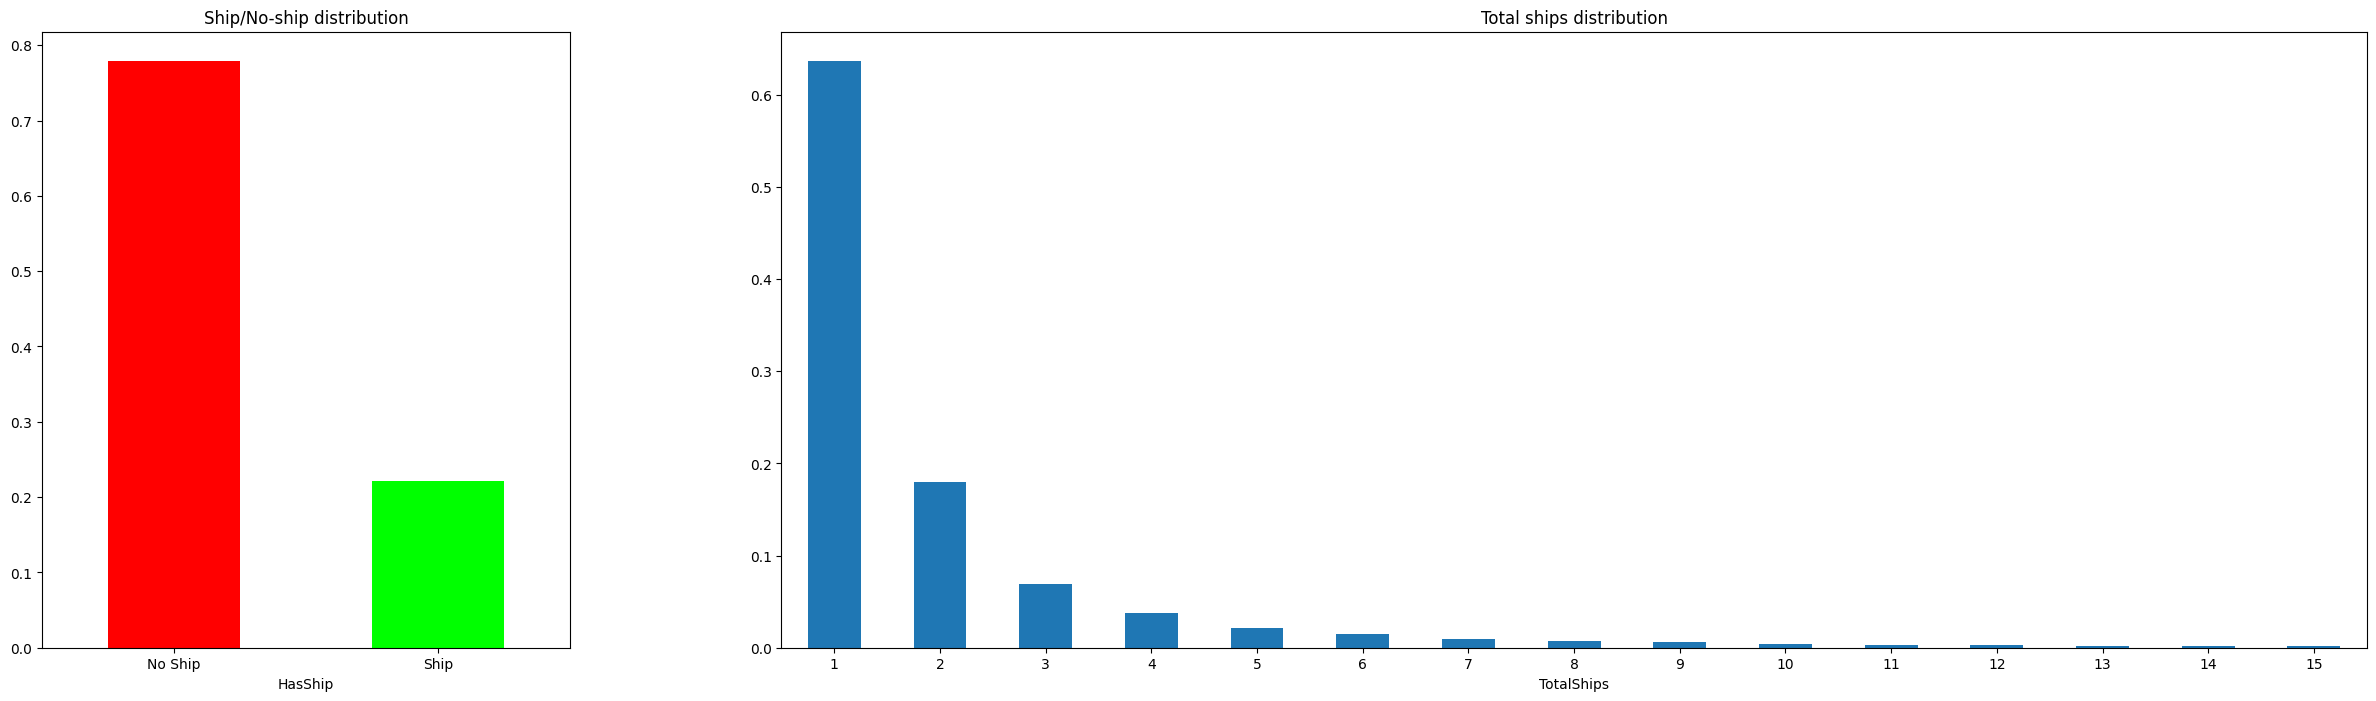

In [145]:
show_df(data)

In [146]:
data['TotalShips'].value_counts()

TotalShips
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

Об'єднаємо картинки на яких декілька кораблів

In [147]:
data = pd.read_csv(os.path.join(data_dir, 'train_ship_segmentations_v2.csv'))

описуємо функцію і додаєм кількість пікселей на яких є суда

In [148]:
data['EncodedPixels'] = data['EncodedPixels'].astype('string')
data['EncodedPixels'] = data['EncodedPixels']+' '
data = data.groupby('ImageId').agg({"EncodedPixels":"sum"}).reset_index()

In [149]:
data.loc[data['EncodedPixels'] == '0', 'EncodedPixels'] = np.NaN

завантажимо цю базу данних у новий файл(гадаю об'єднання однакових рядків покращать результат)

In [150]:
data.to_csv(os.path.join(data_dir, 'train_ship_segmentations_update.csv'), index=False)

описуємо функцію и додаємо у таблицю розміри фотографій. 

In [151]:
def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = np.zeros((768, 768, 3))
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

data = data.apply(lambda x: extract_features_from_image(x), axis=1)

було виявлено що всі фотографії 768 * 768, так прописано щоб швидше працювало, для перевірки замінити 
"image = np.zeros((768, 768, 3))" на 
"image = cv2.imread(os.path.join(data_dir, f'train_v2/{name}'))"

In [152]:
data['ImageHeight'].value_counts()

ImageHeight
768    192556
Name: count, dtype: int64

In [153]:
data['ImageWidth'].value_counts()

ImageWidth
768    192556
Name: count, dtype: int64

Вираховуємо кількість відсоток, який замають кораблі на картинках і будуємо графік

In [154]:
def pixels_number(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()


In [155]:
data['ShipAreaPercentage'] = data.apply(lambda x: pixels_number(x['EncodedPixels']) / 
    (768 * 768) * 100, axis=1)

In [156]:
print(f'There are {data.shape[0]} rows.')
data.head(10)

There are 192556 rows.


,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage
0,00003e153.jpg,<NA>,768,768,0.000000
1,0001124c7.jpg,<NA>,768,768,0.000000
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768,0.574409
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768,0.247531
4,0001b1832.jpg,<NA>,768,768,0.000000
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,768,768,0.199382
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,768,768,0.069173
7,0002d0f32.jpg,<NA>,768,768,0.000000
8,000303d4d.jpg,<NA>,768,768,0.000000
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,768,768,0.072055


In [157]:
data.dropna(subset=['EncodedPixels'], inplace=True)

In [158]:
data.describe()

,ImageHeight,ImageWidth,ShipAreaPercentage
count,42556.0,42556.0,42556.000000
mean,768.0,768.0,0.510319
std,0.0,0.0,0.731965
min,768.0,768.0,0.001695
25%,768.0,768.0,0.036112
50%,768.0,768.0,0.210571
75%,768.0,768.0,0.712755
max,768.0,768.0,13.007270


Text(0.5, 0, '')

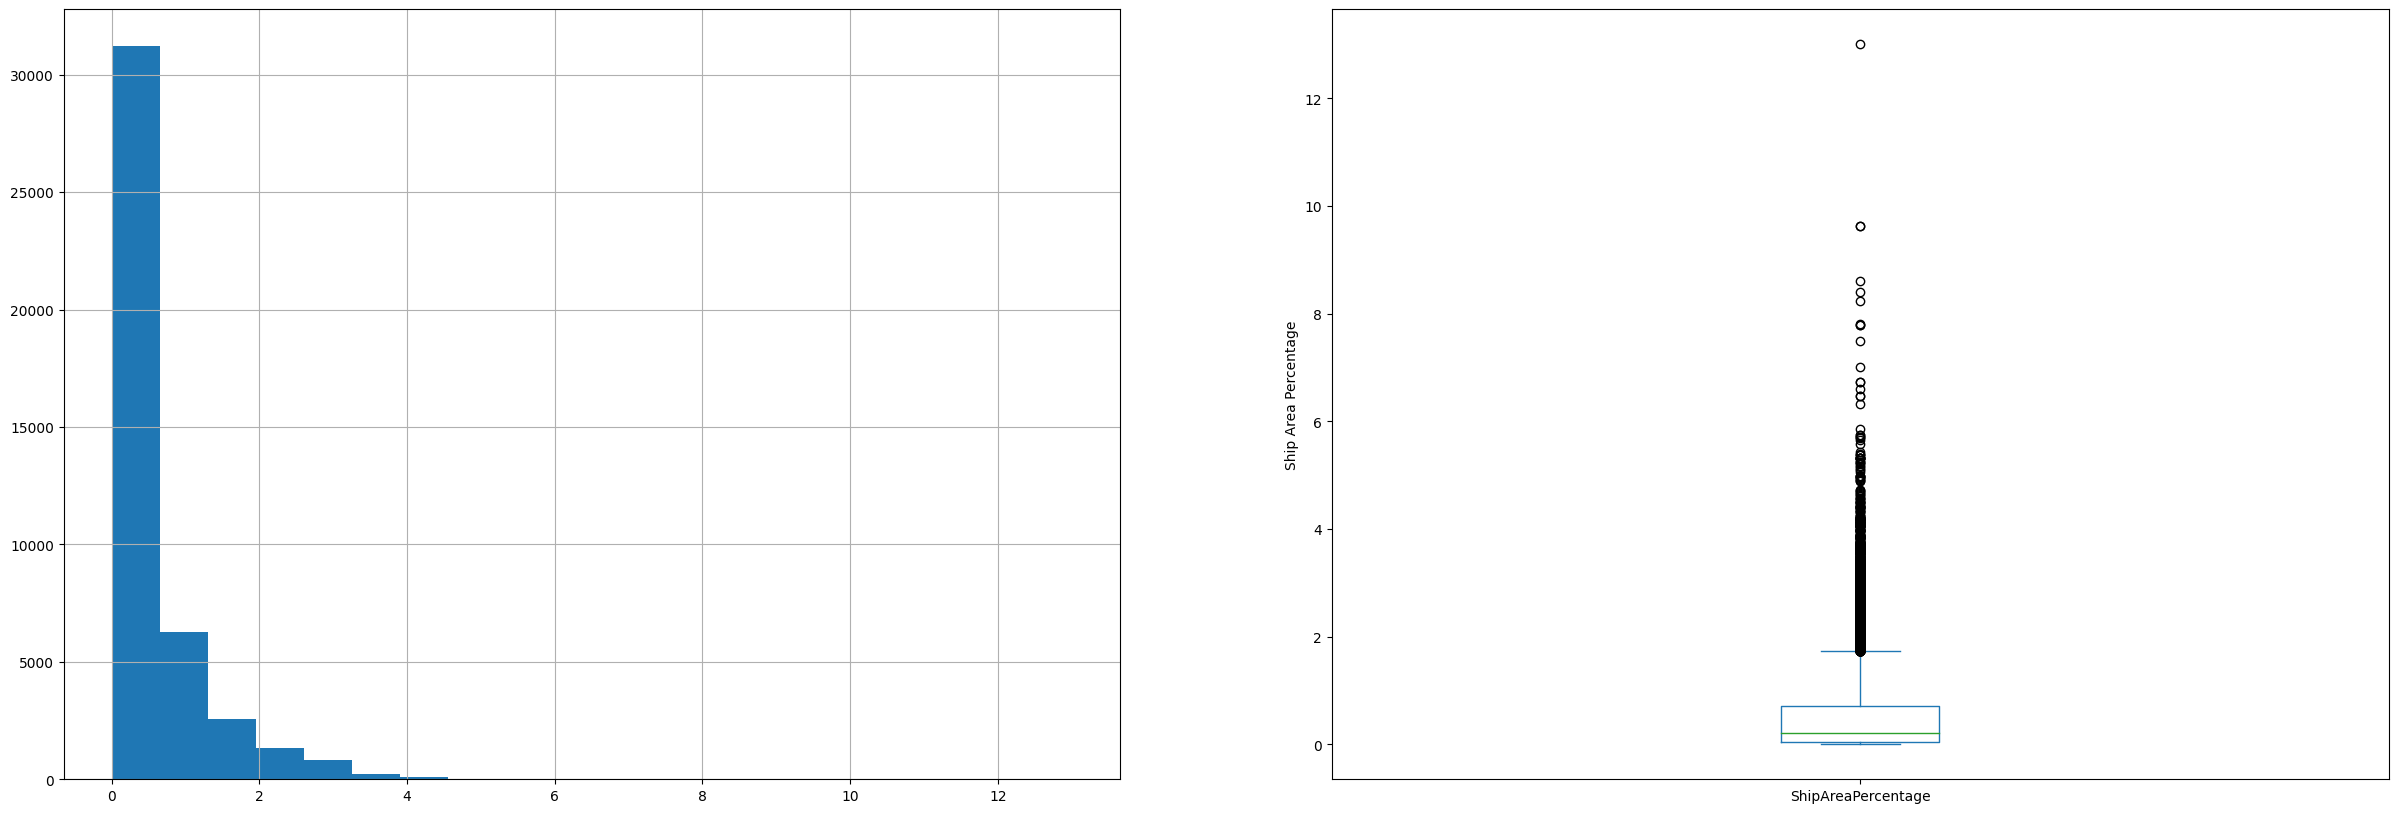

In [159]:
f,ax=plt.subplots(1, 2,figsize=(30,10))

data['ShipAreaPercentage'].hist(bins=20, ax=ax[0])
data['ShipAreaPercentage'].plot.box(ax=ax[1])
ax[1].set_ylabel('Ship Area Percentage')
ax[1].set_xlabel('')


з висновків можна зробити, що на більшості картинок судов нема, для швидкості навчання моделі можна було б видалити частину пустих картинок з бази, але ми цього робити не будемо, бо прискорили час роботи програми іншим способом

На більшості картинок лише по одному судну. Інші ми об'єднали, для покращення навчання моделі. базу данних з об'єднаними картинками зберегли у окремий файл,щоб не змінювати завантаженні данні. Видно що в середньому суда займають менш одного відсотка на картинках, але це не дивно, бодосліджуємо фотографії кораблів на знімках зі супутника. Загалом по висновкам хоч база данних і велика, але більшість з неї пусті фотографії та невеличкі суда, які легко переплутати з хмарами та хвилями, це ще пов'язано з якістю фотографій